In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
#import math

In [3]:
def pre_processamento():
    xlsx = pd.ExcelFile('casos_corona.xlsx')
    df = pd.read_excel(xlsx, 'casos_corona')
    df = df[:5000] ################################limitando o dataset
    df = df[['bairroPaciente','municipioPaciente','resultadoFinalExame','sexoPaciente']]
    bairros = pd.unique(df['bairroPaciente'])

    clusters = []
    for bairro in bairros:
        cluster = []
        for i in range(len(df)):
            if(df.loc[i][0] == bairro):
                if(df.loc[i][2] == 'Positivo'):
                    resultado = 1
                else:
                    resultado = 0
                cluster.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3]])
        clusters.append(cluster)

    novo_df = []
    for cluster in clusters:
        for i in range(len(cluster)):
            novo_df.append(cluster[i])

    novo_df = pd.DataFrame(novo_df)
    novo_df.rename(columns={0: 'bairro_paciente', 1: 'municipio_paciente', 2: 'resultado_exame', 3: 'sexo_paciente'}, inplace=True)    
    return novo_df

In [4]:
df = pre_processamento()

In [5]:
df

,bairro_paciente,municipio_paciente,resultado_exame,sexo_paciente
0,VILA PERI,FORTALEZA,0,MASCULINO
1,VARJOTA,FORTALEZA,0,FEMININO
2,NOVA METROPOLE JUREMA,CAUCAIA,0,FEMININO
3,PARQUE POTIRA JUREMA,CAUCAIA,0,FEMININO
4,PINHEIRO,GUAIÚBA,0,MASCULINO
5,ALDEIA PARK,PACAJUS,0,MASCULINO
6,PRECABURA,EUSEBIO,0,MASCULINO
7,PL CAUCAIA,CAUCAIA,0,MASCULINO
8,JUREMA,CAUCAIA,0,MASCULINO
9,TABAPUA,CAUCAIA,0,FEMININO


In [6]:
def ajustar(df):
    bairros = pd.unique(df['bairro_paciente'])
    casos_bairros = []
    for bairro in bairros:
        count = 0
        for i in range(len(df)):
            if(df.loc[i][0] == bairro):
                count = count + 1
        casos_bairros.append([bairro, count])
    casos_bairros = pd.DataFrame(casos_bairros)
    casos_bairros.rename(columns={0: 'bairro', 1: 'count'}, inplace=True)
    ordem = np.arange(1,len(casos_bairros)+1)#np.arange(-1,-(len(casos_bairros)+1), -1)
    casos_bairros['ordem'] = pd.Series(ordem, index=casos_bairros.index)
    return casos_bairros

In [7]:
dataset = ajustar(df)
dataset

,bairro,count,ordem
0,VILA PERI,1,1
1,VARJOTA,1,2
2,NOVA METROPOLE JUREMA,1,3
3,PARQUE POTIRA JUREMA,1,4
4,PINHEIRO,1,5
5,ALDEIA PARK,1,6
6,PRECABURA,1,7
7,PL CAUCAIA,1,8
8,JUREMA,1,9
9,TABAPUA,1,10


In [8]:
def query_topk(dataset, k):
    copia = dataset.copy()
    output = []
    for i in range(k):
        indice = copia['count'].idxmax()
        output.append([copia.loc[indice][0], copia.loc[indice][1]])#(copia.loc[indice][0])#
        copia.drop(indice, inplace=True,axis=0)
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'bairro', 1: 'count'})
    return output

In [9]:
query_topk(dataset, 10)

,bairro,count
0,CENTRO,4
1,MESSEJANA,2
2,VILA PERI,1
3,VARJOTA,1
4,NOVA METROPOLE JUREMA,1
5,PARQUE POTIRA JUREMA,1
6,PINHEIRO,1
7,ALDEIA PARK,1
8,PRECABURA,1
9,PL CAUCAIA,1


In [10]:
def score_function(registro, saida):
    if(registro[0] == saida):
        return -registro[2]
    else:
        return 0

In [11]:
def sensibilidade(dataset):
    return 1

# LAPLACE

In [66]:
def laplace(budget, sensibilidade, query, dataset, k):
    resposta_query = np.array(query['count'])
    coluna_bairros = np.array(query['bairro'])
    output = []
    np.random.seed(123)
    for i in range(k):
        ruido = stats.laplace.rvs(loc = 0, scale = sensibilidade/budget)
        output.append((resposta_query[i] + ruido))
    dados = {
        'bairro': coluna_bairros,
        'count': output
    }
    
    df = pd.DataFrame(dados, columns = ['bairro', 'count'])
    return df.sort_values(by=['count'],ascending=False)

In [67]:
budgets = [0.1, 1, 10]
counts = []
k = 10
for budget in budgets:
    a = laplace(budget, sensibilidade(dataset), query_topk(dataset, 10), dataset, 10)
    a = np.array(a)
    print("epsilon: {}\ntop-k:\n{}\n\n".format(budget, a))
    counts.append(a[:,1])

epsilon: 0.1
top-k:
[['PINHEIRO' 33.57834888254776]
 ['CENTRO' 8.991249629211602]
 ['NOVA METROPOLE JUREMA' 6.779237549274969]
 ['ALDEIA PARK' 5.6149509319177975]
 ['VARJOTA' 2.082865012547421]
 ['PRECABURA' 0.6111758470501567]
 ['PARQUE POTIRA JUREMA' -0.669842722604737]
 ['PL CAUCAIA' -1.4304651224855673]
 ['MESSEJANA' -3.581292210973028]
 ['VILA PERI' -6.9031268473211655]]


epsilon: 1
top-k:
[['CENTRO' 4.49912496292116]
 ['PINHEIRO' 4.257834888254775]
 ['NOVA METROPOLE JUREMA' 1.577923754927497]
 ['ALDEIA PARK' 1.4614950931917798]
 ['MESSEJANA' 1.4418707789026972]
 ['VARJOTA' 1.108286501254742]
 ['PRECABURA' 0.9611175847050156]
 ['PARQUE POTIRA JUREMA' 0.8330157277395263]
 ['PL CAUCAIA' 0.7569534877514432]
 ['VILA PERI' 0.20968731526788342]]


epsilon: 10
top-k:
[['CENTRO' 4.049912496292116]
 ['MESSEJANA' 1.9441870778902697]
 ['PINHEIRO' 1.3257834888254776]
 ['NOVA METROPOLE JUREMA' 1.0577923754927496]
 ['ALDEIA PARK' 1.046149509319178]
 ['VARJOTA' 1.0108286501254742]
 ['PRECABURA'

In [68]:
erros_laplace = []
k = 10
for count in counts:
    erro = abs(query_topk(dataset, k)['count'] - count)
    erros_laplace.append(np.array(erro))

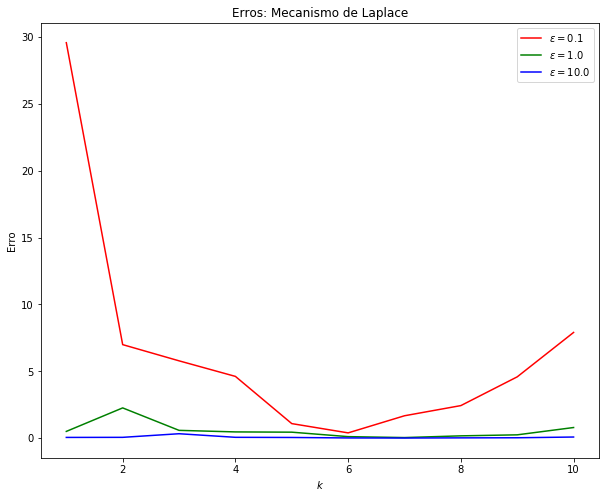

In [83]:
cores = ['red', 'green', 'blue']
eixo_x = np.arange(start=1, stop=k+1, step=1)
fig, ax = plt.subplots(figsize=(10, 8))
for erro, budget, cor in zip(erros_laplace, budgets, cores):    
    plt.plot(eixo_x, erro, ls='-', c=cor, label=r'$\epsilon = %.1f$' % (budget))
    
plt.xlabel('$k$')
plt.ylabel('Erro')
plt.title('Erros: Mecanismo de Laplace')

plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()

# EXPONENCIAL

In [74]:
def dp_query(budget, sensibilidade, dataset, k):
    budget = budget/k
    probabilidades = []
    pk = []
    saidas = dataset['bairro']
    xk = np.arange(len(saidas))
    for out in saidas:
        linha = []
        for i in range(len(dataset)):
            registro = dataset.loc[i]
            numerador = np.exp(budget*score_function(registro,out)/(2*sensibilidade))
            denominador = 0
            for saida in saidas:
                denominador += np.exp(budget*score_function(registro, saida)/(2*sensibilidade))
            linha.append(numerador/denominador)
        probabilidades.append(linha)
    for prob in probabilidades:
        pk.append(np.sum(prob)/np.sum(probabilidades))
    dist = stats.rv_discrete(name='dist', values=(xk, pk))
    output = []

    for i in range(k):
        valido = False
        while(not valido):
            indice = dist.rvs()
            if([saidas[indice], dataset.loc[indice][1]] not in output):
                output.append([saidas[indice], dataset.loc[indice][1]])
                valido = True
        
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'bairro', 1: 'count'})
    return output.sort_values(by=['count'],ascending=False)

In [76]:
budgets = [0.1, 1, 10]
counts = []
k = 10
for budget in budgets:
    a = dp_query(budget, sensibilidade(dataset), dataset, k)
    a = np.array(a)
    print("epsilon: {}\ntop-k:\n{}\n\n".format(budget, a))
    counts.append(a[:,1])

epsilon: 0.1
top-k:
[['MESSEJANA' 2]
 ['PL CAUCAIA' 1]
 ['LAGOA REDONDA' 1]
 ['NOVA METROPOLE JUREMA' 1]
 ['CRUZEIRO' 1]
 ['CAPONGUINHA' 1]
 ['PADRE JULIO MARIA' 1]
 ['ALVARO WEYNE' 1]
 ['SÃO RAIMUNDO' 1]
 ['BARROSO' 1]]


epsilon: 1
top-k:
[['JUREMA' 1]
 ['VICENTE PIZON' 1]
 ['ALVARO WEYNE' 1]
 ['SÃO RAIMUNDO' 1]
 ['NOVA METROPOLE JUREMA' 1]
 ['MEIRELES' 1]
 ['BARROSO' 1]
 ['CRUZEIRO' 1]
 ['PARQUE POTIRA JUREMA' 1]
 ['ITAPAJE' 1]]


epsilon: 10
top-k:
[['CENTRO' 4]
 ['MESSEJANA' 2]
 ['ITAPAJE' 1]
 ['SÃO RAIMUNDO' 1]
 ['PARQUE POTIRA JUREMA' 1]
 ['ALDEIA PARK' 1]
 ['BARROSO' 1]
 ['PIRAJA' 1]
 ['VILA PERI' 1]
 ['VICENTE PIZON' 1]]




In [77]:
erros_exponencial = []
k = 10
for count in counts:
    erro = abs(query_topk(dataset, k)['count'] - count)
    erros_exponencial.append(np.array(erro))

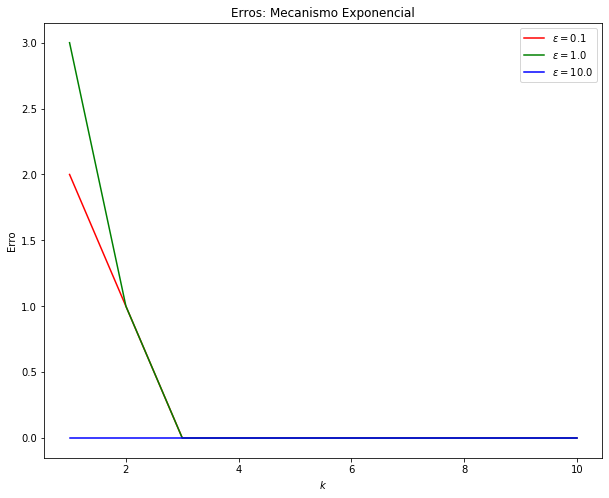

In [81]:
cores = ['red', 'green', 'blue']
eixo_x = np.arange(start=1, stop=k+1, step=1)
fig, ax = plt.subplots(figsize=(10, 8))
for erro, budget, cor in zip(erros_exponencial, budgets, cores):    
    plt.plot(eixo_x, erro, ls='-', c=cor, label=r'$\epsilon = %.1f$' % (budget))
    
plt.xlabel('$k$')
plt.ylabel('Erro')
plt.title('Erros: Mecanismo Exponencial')

plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()

# PLOT COMPARATIVO DE ERROS

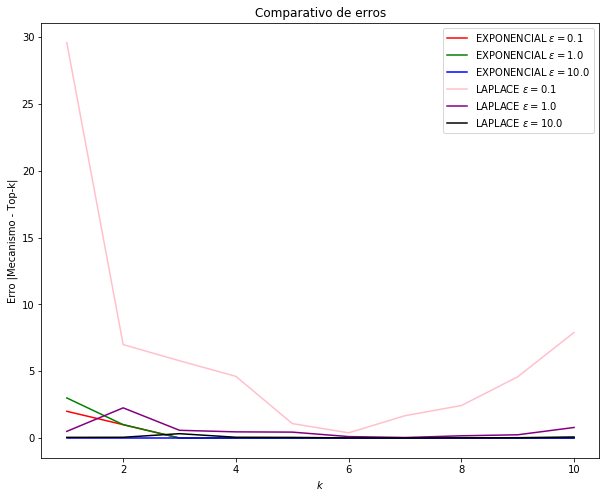

In [80]:
cores_exp = ['red', 'green', 'blue']
cores_lap = ['pink', 'purple', 'black']
eixo_x = np.arange(start=1, stop=k+1, step=1)
fig, ax = plt.subplots(figsize=(10, 8))
for erro, budget, cor in zip(erros_exponencial, budgets, cores_exp):    
    plt.plot(eixo_x, erro, ls='-', c=cor, label=r'EXPONENCIAL $\epsilon= %.1f$' % (budget))

for erro, budget, cor in zip(erros_laplace, budgets, cores_lap):    
    plt.plot(eixo_x, erro, ls='-', c=cor, label=r'LAPLACE $\epsilon= %.1f$' % (budget))

plt.xlabel('$k$')
plt.ylabel('Erro |Mecanismo - Top-k|')
plt.title('Comparativo de erros')

plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()